# Love Number Calculations
In this cookbook we will explore how we can use TidalPy's multilayer functions to estimate the response of a planet to tidal or other loading stresses via the complex Love numbers.

**References**:
- SVC16  : Sabadini, Vermeerson, & Cambiotti (2016), DOI: [10.1007/978-94-017-7552-6](https://doi.org/10.1007/978-94-017-7552-6).
- HH14   : Henning & Hurford (2014), DOI: [10.1088/0004-637X/789/1/30](https://doi.org/10.1088/0004-637X/789/1/30).
- TB05   : Tobie et al. (2005), DOI: [10.1016/j.icarus.2005.04.006](https://doi.org/10.1016/j.icarus.2005.04.006).
- S74    : Saito (1974), DOI: [10.4294/jpe1952.22.123](https://doi.org/10.4294/jpe1952.22.123).
- TS72   : Takeuchi & Saito (1972), DOI: [10.1016/B978-0-12-460811-5.50010-6](http://dx.doi.org/10.1016/B978-0-12-460811-5.50010-6).
- KMN15  : Kamata et al. (1972), DOI: [10.1002/2015JE004821](http://dx.doi.org/10.1002/2015JE004821).
- M16    : Martens (2016, [PhD Thesis](https://resolver.caltech.edu/CaltechTHESIS:04102016-211741759)), DOI: [10.7907/Z9N29TX7](http://dx.doi.org/10.7907/Z9N29TX7).
- ID     : [IcyDwarf Code](https://github.com/MarcNeveu/IcyDwarf/blob/master/IcyDwarf/Thermal.h) written by Marc Neveu.

In [1]:
import sys
import time
from functools import lru_cache

import numpy as np
from ipywidgets import interact, widgets
import matplotlib.pyplot as plt
%matplotlib notebook
from TidalPy.toolbox.conversions import days2rads
from TidalPy.utilities.spherical_helper import calculate_mass_gravity_arrays
from TidalPy.rheology.complex_compliance.compliance_models import maxwell, burgers, andrade, sundberg
from TidalPy.tides.multilayer.numerical_int.solver import radial_solver

rheologies = {
    'Maxwell': maxwell,
    'Burgers': burgers,
    'Andrade': andrade,
    'Sundberg-Cooper': sundberg
}

integrator = 'numba'

widget_styles = {
    'layout': {'width': '50%'},
    'style': {'description_width': 'initial'}
}

def clear_line():
    # Can't get ANSI escape codes to work properly in Jupyter so this is a hack.
    #   The ANSI code would be "\033[1A\033[K"
    print('\r                                             ', end='\r')

## Setup functions

In [20]:
def calculate_planet(build_func):
    
    # Get planet information
    indices, is_solid, bulk_density, \
        radius, density, gravity, shear_modulus, bulk_modulus, viscosity, \
        planet_frequency = build_func()
    radius_km = radius / 1000.
    
    # Setup figure
    fig, axes = plt.subplots(ncols=2)
    ax_radial = axes[0]
    ax_tang   = axes[1]
    ax_radial.set(title='Radial Disp.', ylabel='Radius [km]', xlabel='$y_{1}$ [s$^{2}$ / m]',
                  ylim=(0., radius_km[-1]))
    ax_tang.set(title='Tangential Disp.', xlabel='$y_{3}$ [s$^{2}$ / m]',
                ylim=(0., radius_km[-1]))
    line_radial_tidal, = ax_radial.plot([], [], c='blue', label='Tidal')
    line_tang_tidal, = ax_tang.plot([], [], c='blue', label='Tidal')
    line_radial_load, = ax_radial.plot([], [], c='orange', label='Loading')
    line_tang_load, = ax_tang.plot([], [], c='orange', label='Loading')
    
    @lru_cache
    def update_calculations(rheology_name, forcing_period, degree_l,
                            solid_dynamic, liquid_dynamic, solve_load_numbers,
                            integration_atol, integration_rtol):
        
        # Use pre-defined frequency or user-defined
        if forcing_period == 0.:
            # Pre-defined
            frequency = planet_frequency
        else:
            # Use user-defined
            frequency = days2rads(forcing_period)
        
        # Calculate complex shear
        rheology = rheologies[rheology_name]
        complex_shear = rheology(frequency, shear_modulus**(-1), viscosity)**(-1)
        
        # Setup dynamic or solid assumption
        is_static = list()
        for layer_is_solid in is_solid:
            if layer_is_solid:
                is_static.append(not solid_dynamic)
            else:
                is_static.append(not liquid_dynamic)
        
        # Calculate radial solution
        integration_rtol = 10**integration_rtol
        integration_atol = 10**integration_atol
        y_sol = radial_solver(radius, complex_shear, bulk_modulus, density, gravity,
                              frequency, bulk_density, is_solid, is_static, indices,
                              degree_l, solve_load_numbers=solve_load_numbers,
                              integrator=integrator,
                              integration_rtol=integration_rtol, integration_atol=integration_atol)
        
        # Calculate Love Numbers
        if solve_load_numbers:
            k_tidal = y_sol[0][4, -1] - 1.
            h_tidal = y_sol[0][0, -1] * gravity[-1]
            l_tidal = y_sol[0][2, -1] * gravity[-1]
            k_load = y_sol[1][4, -1] - 1.
            h_load = y_sol[1][0, -1] * gravity[-1]
            l_load = y_sol[1][2, -1] * gravity[-1]
            loves = (k_tidal, h_tidal, l_tidal, k_load, h_load, l_load)
        else:
            k_tidal = y_sol[4, -1] - 1.
            h_tidal = y_sol[0, -1] * gravity[-1]
            l_tidal = y_sol[2, -1] * gravity[-1]
            loves = (k_tidal, h_tidal, l_tidal)
        
        return y_sol, loves
    
    
    def update(rheology_name, forcing_period, degree_l,
               solid_dynamic, liquid_dynamic, solve_load_numbers,
               integration_atol, integration_rtol):
        
        # Perform calculations
        clear_line()
        print('Calculating Radial Solution...', end='\r')
        t0 = time.time()
        y_sol, loves = update_calculations(rheology_name, forcing_period, degree_l,
                                           solid_dynamic, liquid_dynamic, solve_load_numbers,
                                           integration_atol, integration_rtol)
        delta_t = time.time() - t0
        if solve_load_numbers:
            tidal_sol, load_sol = y_sol
            k_tidal, h_tidal, l_tidal, k_load, h_load, l_load = loves
            clear_line()
            out_str = f'Completed in: {delta_t:0.4f}s. ' + 'k_{' + f'{degree_l}' + '}^{T} = ' + \
                  f'{np.real(k_tidal):0.3f}' + '; k_{' + f'{degree_l}' + '}^{L} = ' + \
                  f'{np.real(k_load):0.3f}' + '.'
            print(out_str, end='\r')
        else:
            tidal_sol = y_sol
            k_tidal, h_tidal, l_tidal = loves
            clear_line()
            out_str = f'Completed in: {delta_t:0.4f}s. ' + r'k_{' + f'{degree_l}' + r'}^{T} = ' + \
                  f'{np.real(k_tidal):0.3f}' + '.'
            print(out_str, end='\r')
        
#         # Update plot axis
#         ax_radial.clear()
#         ax_tang.clear()
        
        # Plot Tidal Results
        line_radial_tidal.set_data(np.real(tidal_sol[0, :]), radius_km)
        line_tang_tidal.set_data(np.real(tidal_sol[2, :]), radius_km)
        max_radial = np.nanmax(np.real(tidal_sol[0, :]))
        min_radial = np.nanmin(np.real(tidal_sol[0, :]))
        max_tang = np.nanmax(np.real(tidal_sol[2, :]))
        min_tang = np.nanmin(np.real(tidal_sol[2, :]))
        
        # Plot Load (if applicable)
        if solve_load_numbers:
            line_radial_load.set_data(np.real(load_sol[0, :]), radius_km)
            line_tang_load.set_data(np.real(load_sol[2, :]), radius_km)
            ax_radial.legend(loc='best')
            max_radial = max(max_radial, np.nanmax(np.real(load_sol[0, :])))
            min_radial = min(min_radial, np.nanmin(np.real(load_sol[0, :])))
            max_tang = max(max_tang, np.nanmax(np.real(load_sol[2, :])))
            min_tang = min(min_tang, np.nanmin(np.real(load_sol[2, :])))
            
        # Update limits
        ax_radial.set(xlim=(min_radial*0.9, max_radial*1.1))
        ax_tang.set(xlim=(min_tang*0.9, max_tang*1.1))
        
        # Reshow plot
        fig.canvas.draw()
        
    # Setup interactive plot
    interact(update,
             rheology_name = widgets.Dropdown(
                 options=['Maxwell', 'Burgers', 'Andrade', 'Sundberg-Cooper'],
                 value='Andrade',
                 description='Rheology:',
                 disabled=False, **widget_styles
             ),
             forcing_period = widgets.IntSlider(
                 min=0,
                 max=50,
                 step=1,
                 value=0,
                 description='Forcing Period [Days]:', **widget_styles
             ),
             degree_l = widgets.IntSlider(
                 min=2,
                 max=5,
                 step=1,
                 value=2,
                 description='Degree $l$:', **widget_styles
             ),
             solid_dynamic = widgets.Checkbox(
                 value=False,
                 description='Dynamic Solid',
                 disabled=False,
                 indent=False, **widget_styles
             ),
             liquid_dynamic = widgets.Checkbox(
                 value=False,
                 description='Dynamic Liquid (Unstable!)',
                 disabled=False,
                 indent=False, **widget_styles
             ),
             solve_load_numbers = widgets.Checkbox(
                 value=False,
                 description='Solve Load Numbers',
                 disabled=False,
                 indent=False, **widget_styles
             ),
             integration_atol = widgets.IntSlider(
                 min=-15,
                 max=-3,
                 step=1,
                 value=-7,
                 description='Integration atol ($10^{x}$):', **widget_styles
             ), 
             integration_rtol = widgets.IntSlider(
                 min=-15,
                 max=-3,
                 step=1,
                 value=-6,
                 description='Integration rtol ($10^{x}$):', **widget_styles
             ),
            )

## Four Layer Planet (Mercury-like)

<IPython.core.display.Javascript object>


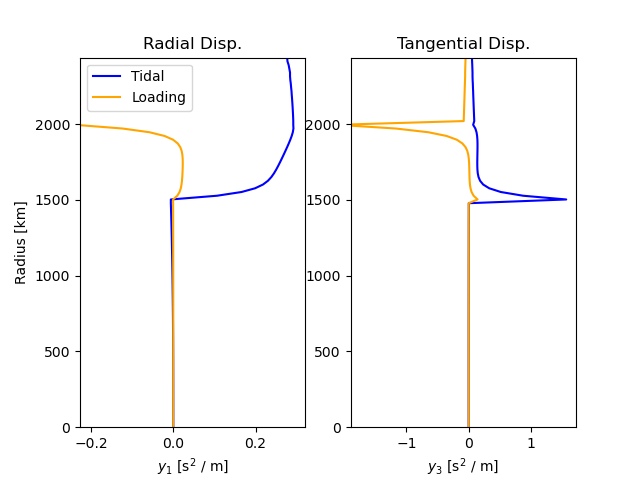

interactive(children=(Dropdown(description='Rheology:', index=2, layout=Layout(width='50%'), options=('Maxwell…

In [21]:
# ! test r0 = 0

def build_four_layer():
    # Numerical Settings
    N = 100

    # Build Planet
    # # Radius
    inner_core_radius = 1500.0e3
    outer_core_radius = 2000.0e3
    crust_radius      = 2440.0e3
    mantle_radius     = crust_radius - 100.0e3

    # # Index
    radius = np.linspace(0.1, crust_radius, N)
    inner_core_index = radius <= inner_core_radius
    outer_core_index = np.logical_and(radius > inner_core_radius,
                                      radius <= outer_core_radius)
    mantle_index     = np.logical_and(radius > outer_core_radius,
                                      radius <= mantle_radius)
    crust_index      = radius > mantle_radius
    
    # # Layer Parameters
    indices = (inner_core_index, outer_core_index, mantle_index, crust_index)
    is_solid = (True, False, True, True)

    # # Density
    density = np.empty_like(radius)
    density[inner_core_index] = 8750.
    density[outer_core_index] = 7850.
    density[mantle_index]     = 3200.
    density[crust_index]      = 2600.

    # # Shear Modulus
    shear_modulus = np.empty_like(radius)
    shear_modulus[inner_core_index] = 100.0e9
    shear_modulus[outer_core_index] = 0.0
    shear_modulus[mantle_index]     = 50.0e9
    shear_modulus[crust_index]      = 10.0e9

    # # Bulk Modulus
    bulk_modulus = np.empty_like(radius)
    bulk_modulus[inner_core_index] = 199.0e9
    bulk_modulus[outer_core_index] = 80.0e9
    bulk_modulus[mantle_index]     = 120.0e9
    bulk_modulus[crust_index]      = 90.0e9

    # # Viscosity
    viscosity = np.empty_like(radius)
    viscosity[inner_core_index] = 1.0e24
    viscosity[outer_core_index] = 1000.0
    viscosity[mantle_index]     = 1.0e20
    viscosity[crust_index]      = 1.0e26

    # # Gravity 
    volume, mass, gravity = calculate_mass_gravity_arrays(radius, density)
    bulk_density = np.sum(mass) / np.sum(volume)
    
    # # Orbital Period
    frequency = days2rads(87.96926)
    
    return indices, is_solid, bulk_density, radius, density, gravity, shear_modulus, bulk_modulus, viscosity, frequency

calculate_planet(build_four_layer)

## Four Layer Planet (Venus-like)